In [1]:
import os, io, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (7.5, 6.0),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 120
})

RANDOM_STATE = 42
DATA_URL = "https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv"
CSV_PATH = "stars.csv"


## 1) Download & load the dataset

In [2]:
#Download the dataset from the given URL and save it locally
def download_dataset(url: str = DATA_URL, out_path: str = CSV_PATH):
    if not os.path.exists(out_path): #checks if the file already exists locally
        urllib.request.urlretrieve(url, out_path)

#Load the dataset from the CSV file and prepare it for analysis (returns a dataframe)
def load_and_prepare(path: str = CSV_PATH):
    df = pd.read_csv(path)
    le = LabelEncoder()
    df['Star type'] = le.fit_transform(df['Star type'])
    labels = le.inverse_transform(df['Star type'])
    class_names = le.classes_
    return df, labels, class_names, le


In [3]:

download_dataset()
df_stars, labels, class_names, label_encoder = load_and_prepare()
display(df_stars.head())
print("Classes (Star type):", list(class_names))
print("Encoded Star type (first 10):", df_stars['Star type'].head(10).tolist())


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Classes (Star type): ['Brown Dwarf', 'Hypergiant', 'Main Sequence', 'Red Dwarf', 'Supergiant', 'White Dwarf']
Encoded Star type (first 10): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



## 2) Data sanity checks (missing values / NaNs)


In [4]:
#check the DataFrame for missing values and NaNs in numeric columns
def check_missing_and_nans(df: pd.DataFrame):
    print("DataFrame shape:", df.shape)    
    print("\nMissing values by column (isna().sum()):\n", df.isna().sum())
    numeric_cols = [c for c in df.columns if df[c].dtype != 'object']
    print("\nNumeric columns:", numeric_cols)
    print("Any NaNs in numeric columns? ->", df[numeric_cols].isna().any().any())

In [5]:

check_missing_and_nans(df_stars)


DataFrame shape: (240, 7)

Missing values by column (isna().sum()):
 Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

Numeric columns: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']
Any NaNs in numeric columns? -> False



## 3) Reproduce the HR diagram (log–log)


In [6]:
#Plot a HR diagram from the dataset (using the given labels)
def hr_scatter(df: pd.DataFrame, labels, palette: str = "tab10"):
    fig, ax = plt.subplots(figsize=(7.8,7.0))
    fig.subplots_adjust(right=0.78)
    sns.scatterplot(data=df, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels,
                    palette=palette, s=40, edgecolor=None, ax=ax)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Temperature [K]'); ax.set_ylabel('Luminosity [L/L$_\\odot$]')
    ax.set_xlim(5e4, 1.5e3)  # invert HR x-axis
    ax.set_title('HR diagram (log–log)')
    leg = ax.legend(title='Star type', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.0)
    plt.show()


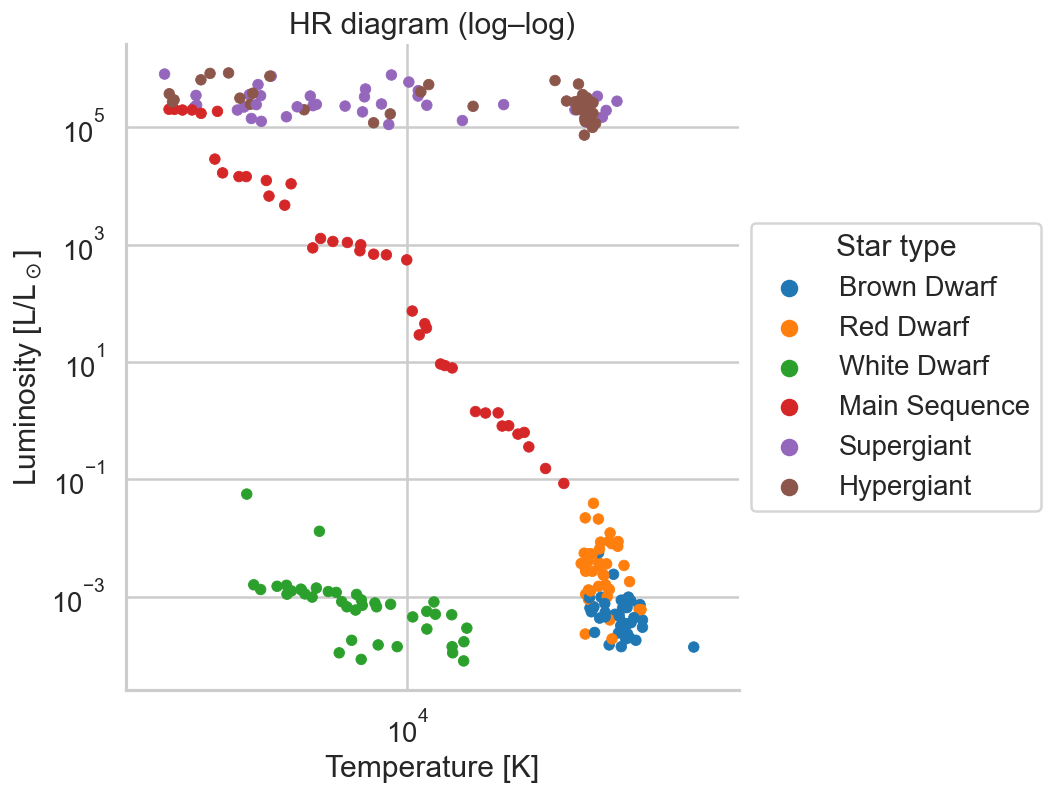

In [7]:

hr_scatter(df_stars, labels)



## 4) PCA without scaling


In [8]:
#Extract the numerical feature matrix from the dataset (relevant quantitative features needed for dimensionality reduction (PCA))
def get_feature_matrix(df: pd.DataFrame):
    num_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
    X = df[num_cols].to_numpy(dtype=float)
    return X, num_cols

# Apply Principal Component Analysis (PCA) to reduce dimensionality
def pca_fit_transform(X: np.ndarray, n_components: int = 2, random_state: int = RANDOM_STATE):
    pca = PCA(n_components=n_components, random_state=random_state) #fitted PCA model, which can be used to inspect explained variance
    Z = pca.fit_transform(X)  #The transformed data in the reduced PCA space
    return Z, pca

#Scatter plot of the dataset in the PCA-transformed space
def plot_pca_scatter(Z: np.ndarray, labels, title: str):
    fig, ax = plt.subplots(figsize=(7.8,6.2))
    fig.subplots_adjust(right=0.78)
    sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels, s=40, edgecolor=None, ax=ax)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    ax.set_title(title)
    ax.legend(title='Star type', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.0)
    plt.show()

Explained variance ratio (raw): [0.99760631 0.0023879 ]
Total variance explained by PC1+PC2 (raw): 0.9999942118846565


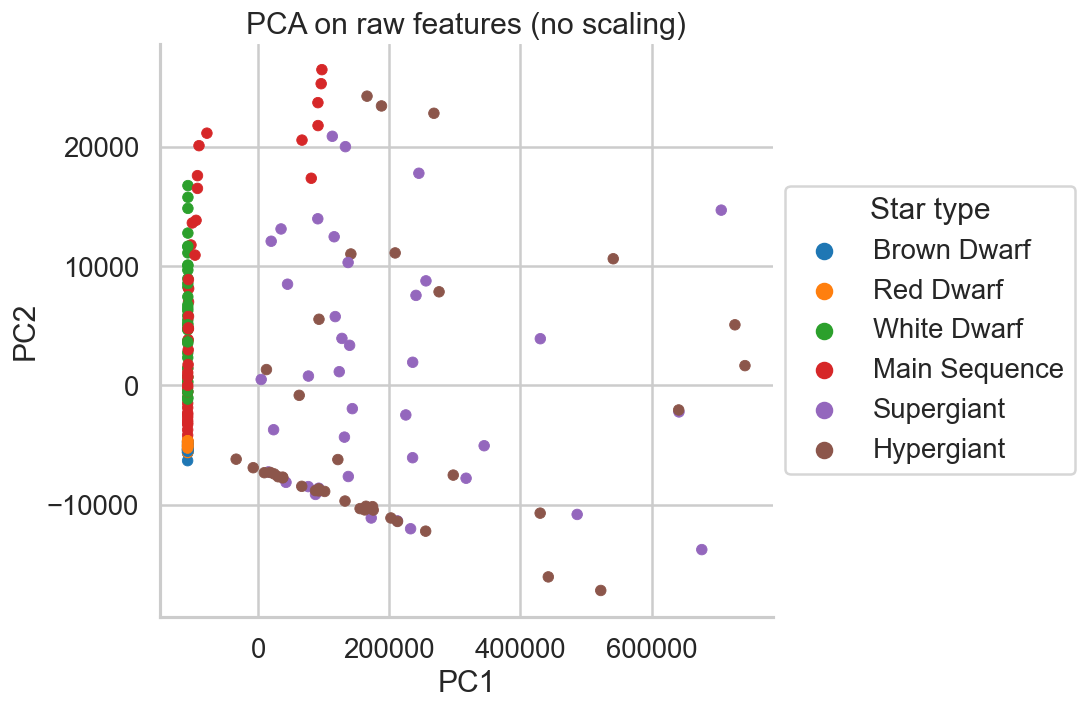

In [9]:

X, feature_names = get_feature_matrix(df_stars)
Z_raw, pca_raw = pca_fit_transform(X, n_components=2)
print("Explained variance ratio (raw):", pca_raw.explained_variance_ratio_)
print("Total variance explained by PC1+PC2 (raw):", pca_raw.explained_variance_ratio_.sum())
plot_pca_scatter(Z_raw, labels, title="PCA on raw features (no scaling)")



## 5) PCA after Min-Max scaling to [-1, 1]


In [10]:
# Apply Min-Max scaling to rescale the feature matrix (each feautures goes between -1 and 1)
def minmax_scale(X: np.ndarray, feature_range=(-1,1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    return scaler.fit_transform(X), scaler

Explained variance ratio (Min-Max): [0.63752162 0.21432776]
Total variance explained by PC1+PC2 (Min-Max): 0.8518493759390561


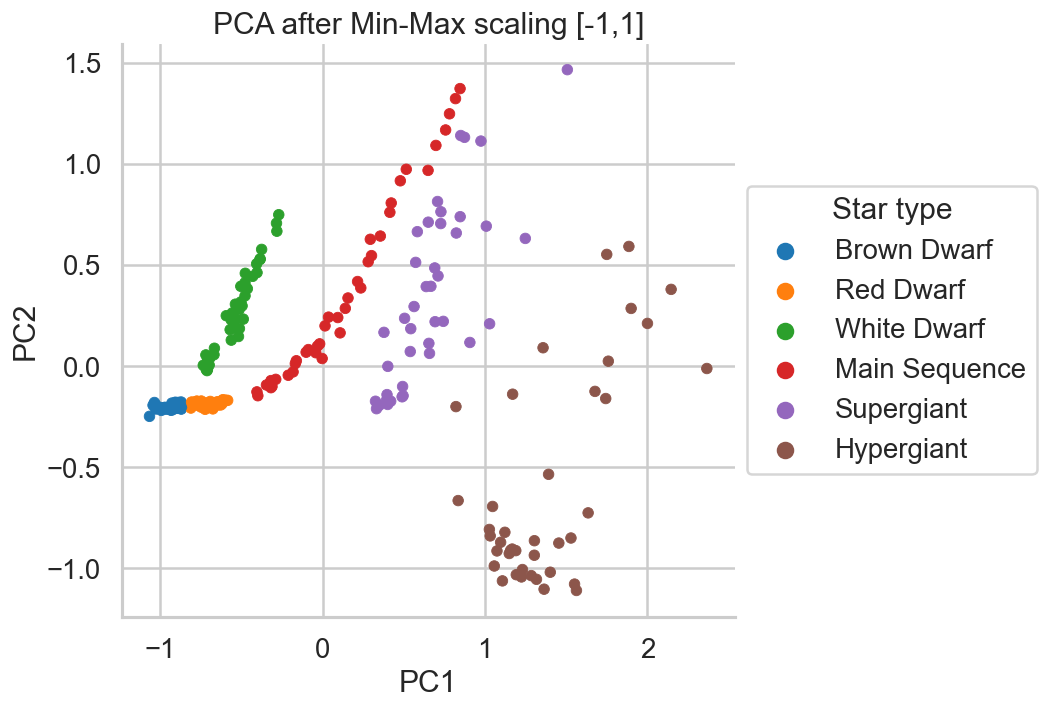

In [11]:

X_mm, mm_scaler = minmax_scale(X, feature_range=(-1,1))
Z_mm, pca_mm = pca_fit_transform(X_mm, n_components=2)
print("Explained variance ratio (Min-Max):", pca_mm.explained_variance_ratio_)
print("Total variance explained by PC1+PC2 (Min-Max):", pca_mm.explained_variance_ratio_.sum())
plot_pca_scatter(Z_mm, labels, title="PCA after Min-Max scaling [-1,1]")



## 6) PCA after Standardization (mean=0, variance=1)


In [12]:
#Apply standardization (z-score normalization) to the feature matrix (each dimension has mean=0 and variance=1).
def standardize(X: np.ndarray):
    scaler = StandardScaler()
    return scaler.fit_transform(X), scaler

Explained variance ratio (Standardized): [0.60357391 0.23500784]
Total variance explained by PC1+PC2 (Standardized): 0.838581750804348


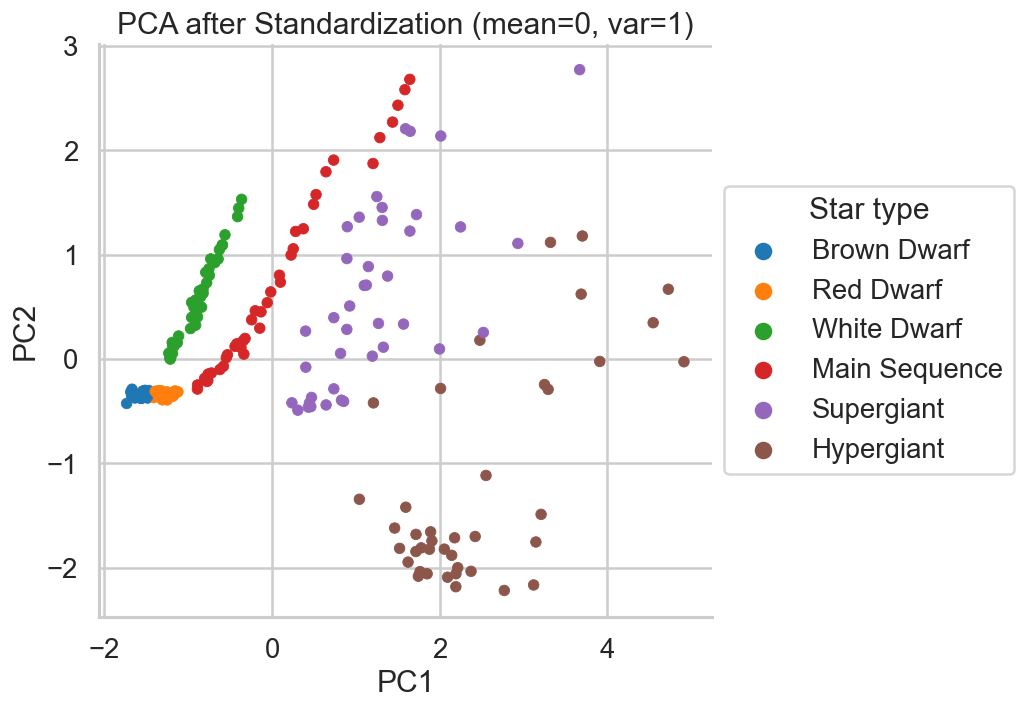

In [13]:

X_std, std_scaler = standardize(X)
Z_std, pca_std = pca_fit_transform(X_std, n_components=2)
print("Explained variance ratio (Standardized):", pca_std.explained_variance_ratio_)
print("Total variance explained by PC1+PC2 (Standardized):", pca_std.explained_variance_ratio_.sum())
plot_pca_scatter(Z_std, labels, title="PCA after Standardization (mean=0, var=1)")
